<a href="https://colab.research.google.com/github/nyee88/Brilliant/blob/main/OCSR-CLIP/OCSR-mutation-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip -q install fastai torchvision
!apt-get -qq update
!pip install rdkit

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 46.6 MB/s eta 0:00:00


In [5]:
from __future__ import annotations

import random, hashlib
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import fastai
from fastai.vision.all import *

# RDKit
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

print("torch:", torch.__version__)
print("fastai:", fastai.__version__)
print("cuda available:", torch.cuda.is_available())

torch: 2.9.0+cpu
fastai: 2.8.6
cuda available: False


In [11]:
# Cell 4 (REPLACE YOUR CURRENT ONE): mutation utilities only (no rendering here)

from dataclasses import dataclass
import random
from rdkit import Chem

@dataclass
class MutationConfig:
    max_tries: int = 50
    atom_pool: tuple[int, ...] = (6, 7, 8, 9, 15, 16, 17, 35)  # C N O F P S Cl Br
    allow_ring_break: bool = False

def _sanitize_or_none(mol: Chem.Mol) -> Chem.Mol | None:
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception:
        return None

def mutate_mol(mol: Chem.Mol, cfg: MutationConfig, rng: random.Random) -> Chem.Mol | None:
    """Return a mutated mol (or None). Mutations are intentionally small."""
    if mol is None:
        return None

    actions = ["atom_sub", "bond_order", "add_methyl", "delete_terminal"]
    action = rng.choice(actions)

    rw = Chem.RWMol(mol)
    atom_idxs = [a.GetIdx() for a in rw.GetAtoms() if a.GetAtomicNum() > 1]
    if not atom_idxs:
        return None

    if action == "atom_sub":
        idx = rng.choice(atom_idxs)
        atom = rw.GetAtomWithIdx(idx)
        atom.SetAtomicNum(int(rng.choice(cfg.atom_pool)))
        return _sanitize_or_none(rw.GetMol())

    if action == "bond_order":
        bonds = list(rw.GetBonds())
        if not bonds:
            return None
        b = rng.choice(bonds)
        if b.GetIsAromatic():
            return None
        bt = b.GetBondType()
        if bt == Chem.BondType.SINGLE:
            b.SetBondType(Chem.BondType.DOUBLE)
        elif bt == Chem.BondType.DOUBLE:
            b.SetBondType(Chem.BondType.SINGLE)
        else:
            return None
        return _sanitize_or_none(rw.GetMol())

    if action == "add_methyl":
        idx = rng.choice(atom_idxs)
        c_idx = rw.AddAtom(Chem.Atom(6))
        rw.AddBond(idx, c_idx, Chem.BondType.SINGLE)
        return _sanitize_or_none(rw.GetMol())

    if action == "delete_terminal":
        terminals = []
        for a in rw.GetAtoms():
            if a.GetAtomicNum() > 1 and a.GetDegree() == 1:
                if (not cfg.allow_ring_break) and a.IsInRing():
                    continue
                terminals.append(a.GetIdx())
        if not terminals:
            return None
        rw.RemoveAtom(int(rng.choice(terminals)))
        return _sanitize_or_none(rw.GetMol())

    return None

def mutate_smiles(
    smi: str,
    steps: int = 1,
    seed: int = 0,
    cfg: MutationConfig = MutationConfig()
) -> str | None:
    """Apply 1..steps small mutations; return canonical mutated SMILES != original, else None."""
    smi0 = canonical_smiles(smi)
    if smi0 is None:
        return None

    rng = random.Random(seed)
    curr = smi0

    for _ in range(steps):
        found = None
        for _try in range(cfg.max_tries):
            mol = Chem.MolFromSmiles(curr)
            if mol is None:
                break
            m2 = mutate_mol(mol, cfg, rng)
            if m2 is None:
                continue
            s2 = Chem.MolToSmiles(m2, canonical=True)
            if s2 and s2 != smi0:
                found = s2
                curr = found
                break
        if found is None:
            return None

    return canonical_smiles(curr)

# sanity check (text only)
orig = canonical_smiles("CCOC(=O)C1=CC=CC=C1")
mut  = mutate_smiles(orig, steps=1, seed=123)
print("orig:", orig)
print("mut :", mut)
print("mutated?", mut is not None and mut != orig)


orig: CCOC(=O)c1ccccc1
mut : CCOC(=N)c1ccccc1
mutated? True


saved: ocsr_mutation_fastai_demo/img_cache/8448043181b9a6b0.png | exists: True


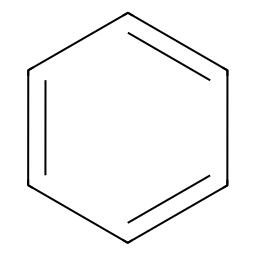

In [12]:
# Cell 5 (NEXT): render SMILES -> PNG + cache helper (ensure_img_for_smiles)

import hashlib
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def sha_id(s: str, n: int = 16) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:n]

def smiles_to_png(
    smi: str,
    out_path: Path,
    size: int = 256,
    line_width: int = 2,
    seed: int = 0,
) -> bool:
    """Render SMILES to a PNG file. Returns True on success."""
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return False

        rdDepictor.SetPreferCoordGen(True)
        rdDepictor.Compute2DCoords(mol)

        drawer = rdMolDraw2D.MolDraw2DCairo(size, size)
        opts = drawer.drawOptions()
        opts.bondLineWidth = line_width

        # tiny deterministic variation
        random.seed(seed)
        opts.additionalAtomLabelPadding = random.choice([0.0, 0.05, 0.1])

        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()

        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_bytes(drawer.GetDrawingText())
        return True
    except Exception as e:
        print("Render failed:", e)
        return False

def ensure_img_for_smiles(smi: str, img_dir: Path, size: int = 256) -> Path | None:
    """Canonicalize SMILES, render to a stable filename, and return the path."""
    smi_c = canonical_smiles(smi)
    if smi_c is None:
        return None

    out = img_dir / f"{sha_id(smi_c)}.png"
    if out.exists():
        return out

    seed = int(sha_id(smi_c, 6), 16) % 10_000
    ok = smiles_to_png(smi_c, out, size=size, seed=seed)
    return out if ok else None

# set up cache dir
PROJECT = Path("ocsr_mutation_fastai_demo")
IMG_DIR = PROJECT / "img_cache"
IMG_DIR.mkdir(parents=True, exist_ok=True)

# sanity: render + display
from PIL import Image
from IPython.display import display

p = ensure_img_for_smiles("c1ccccc1", IMG_DIR)
print("saved:", p, "| exists:", p.exists() if p else None)
display(Image.open(p))


                                                       img1  \
0  ocsr_mutation_fastai_demo/img_cache/cb22c32e46efb7b3.png   
1  ocsr_mutation_fastai_demo/img_cache/89b394fd02e5e5e6.png   
2  ocsr_mutation_fastai_demo/img_cache/e1be659eb9b8ee84.png   
3  ocsr_mutation_fastai_demo/img_cache/35326b933c862842.png   
4  ocsr_mutation_fastai_demo/img_cache/e0493e44e8e4d1bd.png   

                                                       img2 label  
0  ocsr_mutation_fastai_demo/img_cache/cb22c32e46efb7b3.png  same  
1  ocsr_mutation_fastai_demo/img_cache/35326b933c862842.png  diff  
2  ocsr_mutation_fastai_demo/img_cache/cca99a9c36f043c4.png  diff  
3  ocsr_mutation_fastai_demo/img_cache/35326b933c862842.png  same  
4  ocsr_mutation_fastai_demo/img_cache/e0493e44e8e4d1bd.png  same  
N: 20 | same: 10 | diff: 10
label: diff


[00:05:02] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9


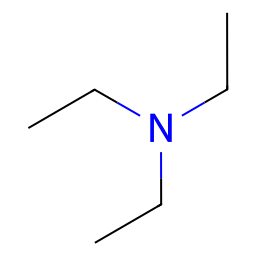

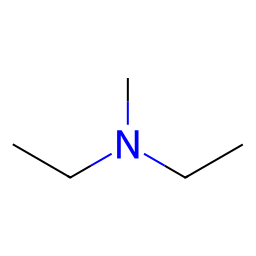

In [15]:
# Cell 6 (PAIR DATASET): build (img1, img2) pairs labeled same/diff

import pandas as pd
import random

def make_pairs_dataframe(
    smiles_list: list[str],
    img_dir: Path,
    n_samples: int = 2000,
    neg_per_pos: int = 1,
    mutate_steps: int = 1,
    size: int = 256,
    seed: int = 42,
) -> pd.DataFrame:
    """
    Returns df with columns: img1, img2, label in {'same','diff'}
    - positives: (img(original), img(original)) -> same
    - negatives: (img(original), img(mutated(original))) -> diff
    """
    rng = random.Random(seed)

    # canonicalize and de-dup
    canon = []
    for s in smiles_list:
        c = canonical_smiles(s)
        if c:
            canon.append(c)
    canon = sorted(set(canon))
    if len(canon) < 10:
        raise ValueError("Need more valid SMILES to build a useful dataset.")

    rng.shuffle(canon)
    base = canon[: min(n_samples, len(canon))]

    rows = []
    for i, smi in enumerate(base):
        p1 = ensure_img_for_smiles(smi, img_dir, size=size)
        if p1 is None:
            continue

        rows.append({"img1": str(p1), "img2": str(p1), "label": "same"})

        for j in range(neg_per_pos):
            mut = mutate_smiles(smi, steps=mutate_steps, seed=seed + i * 100 + j)
            if mut is None: # The syntax error was here
                continue
            p2 = ensure_img_for_smiles(mut, img_dir, size=size)
            if p2 is None:
                continue
            rows.append({"img1": str(p1), "img2": str(p2), "label": "diff"})

    df = pd.DataFrame(rows).dropna()
    if df.empty:
        raise ValueError("No pairs were generated. Try lowering mutate_steps or increasing n_samples.")

    # balance classes (helps training + debugging)
    same = df[df.label == "same"]
    diff = df[df.label == "diff"]
    m = min(len(same), len(diff))
    df = pd.concat(
        [same.sample(m, random_state=seed), diff.sample(m, random_state=seed)],
        ignore_index=True
    ).sample(frac=1.0, random_state=seed).reset_index(drop=True)

    return df

# smoke test
toy_smiles = [
    "CCO", "CC(=O)O", "c1ccccc1", "CCN(CC)CC", "CC(=O)NC1=CC=CC=C1",
    "COC1=CC=CC=C1O", "CCOC(=O)C1=CC=CC=C1", "CC(C)O", "CN1CCCC1=O",
    "CC(C)CC1=CC=C(C=C1)O",
] * 80

df = make_pairs_dataframe(
    toy_smiles,
    img_dir=IMG_DIR,
    n_samples=400,
    neg_per_pos=1,
    mutate_steps=1,
    size=256,
    seed=42
)

print(df.head())
print("N:", len(df), "| same:", (df.label=="same").sum(), "| diff:", (df.label=="diff").sum())

# visualize one random pair
row = df.sample(1, random_state=0).iloc[0]
print("label:", row["label"])
display(Image.open(row["img1"]))
display(Image.open(row["img2"]))